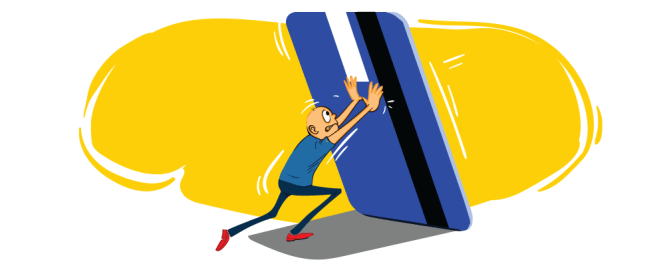

##### In the peresent notebook, I am trying to analyze the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) data set. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled `default.payment.next.month` in the data. 
##### For this, a Machine Learning pipeline is built to analyze the impact of the features on the target and make predictions down the road.

In [ ]:
# Your imports
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import lognorm, loguniform, randint
import seaborn as sns
import xgboost as xgb
import altair as alt


# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LogisticRegression, Ridge

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score, 
    make_scorer, 
    recall_score
)

##### 1- Understanding the problem

In [ ]:
credit_df = pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv' , index_col = 0)
credit_df

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. The target predicts whether a client **will** default on their credit card payment (class `1`) **or not** (class `0`).

##### 2- Splitting the data

In [ ]:
# Splitting the data into train and test sets
train_df, test_df = train_test_split(credit_df, test_size=0.2, random_state=123)
train_df.head()

##### 3- Explaratory Data Analysis

Now let's run an EDA on the train set.

In [ ]:
# Performing EDA on the train set
train_df.head()

How about a general overview of the train set!

In [ ]:
# Overview of the train set
train_df.info()

**Above is the overall information about the train dataframe, the `Columns`, `Non-Null Counts` and `Data Types`.**

In [ ]:
# Summary of statistics of the train set
train_df.describe()

**Above is the statistical information about different features in the train dataframe.**

In [ ]:
# Examining the distribution of the target values in target (class imbalance)
dist = train_df["default.payment.next.month"].value_counts(normalize=True)
dist[0]
dist_df = pd.DataFrame([
      {"Target": "Target: 0", "Distribution": dist[0]},
      {"Target": "Target: 1", "Distribution": dist[1]}

])

# Examining the distribution of the target values in target (class imbalance)
alt.Chart(dist_df).mark_bar().encode(
    x=alt.X('Target'),
    y='Distribution')

**Above is a visualization to demonstrate the distribution of the target, which proves the class imbalance**

In [ ]:
# Checking the distribution of features and the target
train_df.hist(figsize=(20,20), bins=20);

The initial observations of the data can be summarized below:

- This data set does not have too many features. The feature ranges are quite different, therefore scaling seems necessary.
- There are no NaN values so there is no need for imputation. 
- We have quite a few outliers.
- We have class imbalance since almost 78% of the target class is "0" (client WILL NOT default) and only 22% is "1" (client WILL default). We need to deal with this, since the "1" class (client WILL default) is what we want to spot and care about whereas in this case, the number of the observations in the target is biased towards the "0" class. Here, I choose `f1` score as the metric where both classes get equal weight.
- Based on the information on the documentation of `the dataset page on Kaggle`: The `SEX` feature has binary values Sex (1 = male; 2 = female)
- Based on the information on the documentation of `the dataset page on Kaggle`: The `MARIAGE` feature, Marital status (1 = married; 2 = single; 3 = divorce; 0=others), therefore, it is safe to discard the "0" level and assign it to level "3" in Feature Engineering, resulting into: (1 = married; 2 = single; 3 = divorce).
- Based on the information on the documentation of `the dataset page on Kaggle`: The `EDUCATION` feature, Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others), therefore, it is safe to discard the "0", "5" and "6" levels and assign them to level "4" in Feature Engineering, resulting into: (1 = graduate school; 2 = university; 3 = high school; 4 = others)

##### 4- Feature engineering

In [ ]:
# Feature engineering on "MARRIAGE"
train_df["MARRIAGE"].replace(0, 3, inplace=True)
train_df["MARRIAGE"].unique()

In [ ]:
# Feature engineering on "EDUCATION"
train_df["EDUCATION"].replace((0, 5,6), 4, inplace=True)
train_df["EDUCATION"].unique()

##### 5- Preprocessing and transformation

Let's first check the columns of the data set one more time.

In [ ]:
train_df.columns

Now let's specify the different features in the data set.

In [ ]:
# Identifying the target and different features


target = "default.payment.next.month"

binary_features = ["SEX"]
categorical_features = ["EDUCATION", "MARRIAGE"]
numeric_features = list(
    set(train_df.columns) - set(categorical_features) - set(binary_features) - set([target])
)
numeric_features

In [ ]:
# Splitting X and y for train_df and test_df
X_train, y_train = train_df.drop(columns=["default.payment.next.month"]), train_df["default.payment.next.month"]
X_test, y_test = test_df.drop(columns=["default.payment.next.month"]), test_df["default.payment.next.month"]

Now, I need to build the right transformers for each feature type.

In [ ]:
# Defining feature transformers
numeric_transformer = make_pipeline(StandardScaler())

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary"),
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

# Defining the preprocessor (column transformer)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features)
)

Now it is time to do the modeling part of the pipeline. I will first start with a Baseline model. But before that, let's define the scoring metric for this work.

In [ ]:
# Defining the scoring metric
custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

Next, I will define a helper function `mean_std_cross_val_scores` to return cross validation scores for any model in the pipeline.

In [ ]:
# Helper function

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Also a dictionary to store the results.

In [ ]:
# A dictionary to store the results in
results = {}

##### 6- Baseline model

In [ ]:
# Cross-validation with DummyClassifier
pipe_dummy = make_pipeline(preprocessor, DummyClassifier(strategy="stratified"))
results['DummyClassifier'] = mean_std_cross_val_scores(pipe_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results)

Since in our case we have class imbalance biased to the "0" class while the "1" class is what we want to spot, we should be expecting poor results from `DummyClassifier`.

##### 7- Linear models

As the first attempt I will be using `LogisticRegression` model.

In [ ]:
# Defining pipeline for LogisticRegression with class_weight="balanced" and with max_iter = 1000
pipe_lr = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123))

In [ ]:
# Creating a param_grid_random for optimization task  
param_grid_lr = {
                     "logisticregression__C": 10.0**np.arange(-3,3,1)}

random_search_lr= RandomizedSearchCV(pipe_lr, param_distributions=param_grid_lr, n_jobs=-1, scoring=scoring_metric)
random_search_lr.fit(X_train, y_train);

In [ ]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 score from RandomizedSearch: %.3f" % random_search_lr.best_score_)
random_search_lr.best_params_

In [ ]:
# Using the best estimator from RandomizedSearchCV
best_lr = random_search_lr.best_estimator_
best_lr.fit(X_train, y_train)

In [ ]:
# Reporting validation scores along with standard deviation
results['LogisticRegression'] = mean_std_cross_val_scores(best_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results)

According to above results, obviously `LogisticRegression` is getting better validation scores compared to `DummyClassifier`. Since in our case we have `class imbalance` biased to the "0" class while the "1" class is what we want to spot, we should be expecting poor results from `DummyClassifier`.

In both cases it seems like we are underfitting; there is not much gap between train and validation scores. Probably non-linear models might be a better choice here.

##### 8- Other classifiers

Next, I will put three non-linear classifiers, `RandomForestClassifier`, `XGBClassifier` and `LGBMClassifier` into action. On average Ensemble models have a better performance compared to traditional models.

In [ ]:
# Defining pipelines for 3 classifiers with class_weight="balanced" 
models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=123),
    "XGBoost": XGBClassifier(class_weight="balanced", random_state=123),
    "LGBM": LGBMClassifier(class_weight="balanced", random_state=123),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results)

Based on above results, `LightGBM` seems to be the best performing model among the tree-based models (easily beating `LogisticRegression`). It also seems to be much faster and overfitting less compared to `RandomForest` and `XGBoost`. It is worth mentioning that another observation is the overfitting with `RandomForest` model.

##### 9- Feature selection

**Side note**

For Feature celection, `RFECV()` is used with the tree-based models and validation scores will be compared with plain models to better study the effect of possible improvement with feature selection

In [ ]:
# Adding RFECV to the pipeline
for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ Feat_Sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )
pd.DataFrame(results)

We see very small improvements in the result with the models and not a lot. Also, we do not have a large number of features. So it is safe to remove feature selection from the pipeline.

##### 10- Hyperparameter optimization

**Hyperparameter optimization with RandomForest**

In [ ]:
# Hyperparameter Optimization with RandomForest
param_grid_rf = {"randomforestclassifier__n_estimators": [5, 10, 50, 100],
                     "randomforestclassifier__max_depth": [10, 20, 30]}

pipe_rf = make_pipeline(preprocessor, models["RandomForest"])

random_search_rf= RandomizedSearchCV(pipe_rf, param_distributions=param_grid_rf, n_jobs=-1, scoring=scoring_metric)
random_search_rf.fit(X_train, y_train);

In [ ]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_rf.best_score_)
random_search_rf.best_params_

In [ ]:
# Using the best estimator from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

In [ ]:
# Reporting validation scores along with standard deviation
results['Optimized RandomForest'] = mean_std_cross_val_scores(best_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results)

**Hyperparameter optimization with XGBoost**

In [ ]:
# Hyperparameter Optimization with XGBoost
param_grid_xgb = {"xgbclassifier__subsample": [0.6, 0.8, 1.0]
                     }
pipe_xgb = make_pipeline(preprocessor, models["XGBoost"])

random_search_xgb= RandomizedSearchCV(pipe_xgb, param_distributions=param_grid_xgb, n_jobs=-1, n_iter=1000, scoring=scoring_metric)
random_search_xgb.fit(X_train, y_train);

In [ ]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_xgb.best_score_)
random_search_xgb.best_params_

In [ ]:
# Using the best estimator from RandomizedSearchCV
best_xgb = random_search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)

In [ ]:
# Reporting validation scores along with standard deviation
results['Optimized XGBoost'] = mean_std_cross_val_scores(best_xgb, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results)

**Hyperparameter optimization with LGBM**

In [ ]:
# Hyperparameter Optimization with LGBM

param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(preprocessor, models["LGBM"])

random_search_lgbm= RandomizedSearchCV(pipe_lgbm, param_distributions=param_grid_lgbm, n_jobs=-1, n_iter=1000, scoring=scoring_metric)
random_search_lgbm.fit(X_train, y_train);

In [ ]:
# Printing best_score and best_params of hyperparameter optimization
print("Best f1 sore from RandomizedSearch: %.3f" % random_search_lgbm.best_score_)
random_search_lgbm.best_params_

In [ ]:
# Using the best estimator from RandomizedSearchCV
best_lgbm = random_search_lgbm.best_estimator_
best_lgbm.fit(X_train, y_train)

In [ ]:
# Reporting validation scores along with standard deviation
results['Optimized LGBM'] = mean_std_cross_val_scores(best_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric)
pd.DataFrame(results)

Based on above results, Hyperparameter Optimization seems to help with `RandomForest` and a little with `LightGBM` but not `XGBoost`. Although `RandomForest` scores are a little better, here we pick `LightGBM` for the remainder of the work because it is much faster.

##### 11- Interpretation and feature importance

**Side note**

To carry out feature importance evaluation, we will be using the **SHAP** approach and optimized `LightGBM` as one of the best performing models for this example.

In [ ]:
import shap

# Defining feature_names
binary_OHE = list(
    best_lgbm.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names(binary_features)
)


categorical_OHE = list(
    best_lgbm.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)

feature_names = numeric_features + binary_OHE + categorical_OHE

In [ ]:
# Checking the encoded features
preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

In [ ]:
# Defining lgbm_optimized and fitting 
lgbm_optimized = LGBMClassifier(
    class_weight="balanced",
    random_state=123,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_optimized.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_optimized)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

In [ ]:
# Getting SHAP values
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

Based on above results, the `PAY_0` and `LIMIT_BAL` features are of the biggest drivers of the predictions. However, from only these results, we can not determine the direction to which these features drive the predictions as there is no sign associated with them (all positive numbers) and also the fact that `LGBMClassifier` is a non-linear model.

In [ ]:
# Building SHAP dependence plot
shap.dependence_plot("LIMIT_BAL", lgbm_shap_values[0], X_train_enc)

The plot above shows the effect of `LIMIT_BAL` feature on the prediction. Here, the x-axis represents values of the feature `LIMIT_BAL` and the y-axis is the `SHAP` value for that feature, which represents how much knowing that feature's value changes the output. Obviously, higher values of `LIMIT_BAL` result in higher `SHAP` values for class "0" of the target. This suggests that class is likely to be "0" (`non-default`) with higher values for `LIMIT_BAL` which makes sense.  Also, the color corresponds to a second feature (`BILL_AMT2`) that may have an interaction effect with `LIMIT_BAL`.

In [ ]:
# Creating SHAP summary plot
shap.summary_plot(lgbm_shap_values[0], X_train_enc)

The plot shows the most important features for predicting the class. It also shows the direction of how it is going to drive the prediction. Higher `SHAP` value means positive association with class "0" of the target as we are using `SHAP` values for class "0". As an example, higher value of `BILL_AMT1` feature has a high negative impact on the prediction of the target as class "0", or higher value of `LIMIT_BAL` feature has a high positive impact on the prediction of the target as class "0".

##### 12- Results on the test set

**Side note**

Using optimized `LightGBM` as the best performing model for this section.

In [ ]:
# Fitting lgbm_optimized
lgbm_optimized.fit(X_train_enc, y_train)

# Encoding the test set
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

In [ ]:
# Scoring on the test set and comparing with validation results
print("Opimized LightHBM validation score is 0.689")

predictions = lgbm_optimized.predict(X_test_enc)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Based on the results, the test scores above agree well with the validation scores from before.

**Checking the prediction on the following example**

In [ ]:
lgbm_optimized.predict(X_test_enc)[5]

**Explaining with SHAP force plot**

**Force Plot**

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
shap.force_plot(
    lgbm_explainer.expected_value[0], lgbm_shap_values[0][5, :], X_test_enc.iloc[5, :]
)

According to the plot, the base value for class "0" is **0.4287** whereas the score for class "0" here is **0.26**. Features that push the prediction to a higher value are in red, such as `BILL_AMT1` or `PAY_0` and in blue, are features that push the prediction to a lower value such as `LIMIT_BAL` or `PAY_AMT1`. As an example, it is safe to say that higher values for `PAY_3` are likely to predict class "0" for the target.

### Conclusions

In [ ]:
# Tabulating important results
results_df = pd.DataFrame([
      {"Classifier": "DummyClassifier", "Best f1 score": 0.500},
      {"Classifier": "LogisticRegression", "Best f1 score": 0.627},
      {"Classifier": "RandomForest", "Best f1 score": 0.701},
      {"Classifier": "XGBoost", "Best f1 score": 0.676},
      {"Classifier": "LightGBM", "Best f1 score": 0.689},
      {"Classifier": "Test with LightGBM", "Best f1 score": 0.692},

])
results_df

In [ ]:
# Plotting f1 scores for different classifiers

f1_line = alt.Chart(results_df, title='f1 Scores Plot').mark_line().encode(
    x='Classifier',
    y='Best f1 score',
    color= alt.value('black'))
f1_point = alt.Chart(results_df).mark_point().encode(
    x='Classifier',
    y='Best f1 score',
     color= alt.value('black'))

(f1_line + f1_point).properties(
    width=500,
    height=300
)

Since the project is open-ended, there is still room for improvement. We can go much deeper in `Preprocessing`, `Feature Selection`, `Feature Engineering` and `Hyperparameter Optimization`. We can also investigate the performance of other classifiers as well and even make attempts to tune them to get better validation scores. We can summarize the concluding remarks as below:
- As expected `DummyClassifier` has the lowest performance compared to other models and the fact that we have class imbalance within the target makes the results from `DummyClassifier` even more unreliable.
- For our case, a linear model like `LogisticRegression` has an average performance where tree_based models have better performance compared with `LogisticRegression`, among which `LightGBM` has the best performance.
- For the case under study, the performed feature selection with `REFCV` did not improve the scores. Perhaps if enough time is spent on this process, better results are not far from reach.
- Signs of improvement in validation scores are observed with hyperparameter optimization. This is another field which, as mentioned earlier, has the potential to better the scores.
- `LightGBM` classifier, was picked and applied to the test set for which test results agreed well with validation scores and since the dataset is large enough, there is no concern with `optimization bias` for our case.